### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [142]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [122]:
var_name = 'e'
sat_var = 2

In [143]:
Paras = {
     'M0':['M0'],
    'e':['e' ],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [144]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,e
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.01721513770000000082
2017-11-02 01:00:00,0.01721521969999999929
2017-11-02 02:00:00,0.01721531310000000078
2017-11-02 03:00:00,0.01721541749999999996
2017-11-02 04:00:00,0.01721552709999999917


In [145]:
test = df.iloc[265:408,:]

In [146]:

df.head(7)

,e
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.01721513770000000082
2017-11-02 01:00:00,0.01721521969999999929
2017-11-02 02:00:00,0.01721531310000000078
2017-11-02 03:00:00,0.01721541749999999996
2017-11-02 04:00:00,0.01721552709999999917
2017-11-02 05:00:00,0.01721551229999999932
2017-11-02 06:00:00,0.01721513740000000028


In [147]:
df.columns


Index(['e'], dtype='object')

# Enter number of entries per day

In [148]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [149]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [150]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,e
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.01721513770000000082
2017-11-02 01:00:00,0.01721521969999999929
2017-11-02 02:00:00,0.01721531310000000078
2017-11-02 03:00:00,0.01721541749999999996
2017-11-02 04:00:00,0.01721552709999999917


In [151]:
train.tail(6)

,e
Epoch_Time_of_Clock,
2017-11-06 18:00:00,0.01721449809999999955
2017-11-06 19:00:00,0.01721480480000000049
2017-11-06 20:00:00,0.01721518340000000036
2017-11-06 21:00:00,0.01721562880000000045
2017-11-06 22:00:00,0.01721613569999999940
2017-11-06 23:00:00,0.01721669899999999850


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [152]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [153]:
import pickle
file_x = open(var_name+'X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [154]:
tensor_structure = {'X':(range(-T+1, 1),Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [155]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.72173308782287137753  0.72305264655326539902   
2017-11-03 00:00:00  0.72305264655326539902  0.72759192858838472873   
2017-11-03 01:00:00  0.72759192858838472873  0.73487589278418863348   
2017-11-03 02:00:00  0.73487589278418863348  0.74258211577225363698   
2017-11-03 03:00:00  0.74258211577225363698  0.70932923574984230175   
2017-11-03 04:00:00  0.70932923574984230175  0.55979684034247878532   
2017-11-03 05:00:00  0.55979684034247878532  0.33943053225130404016   
2017-11-03 06:00:00  0.33943053225130404016  0.20990264720696924505   
2017-11-03 07:00:00  0.20990264720696924505  0.19053152503599463108   
2017-11-03 08:00:00  0.19053152503599463108  0.15696195091572504032   
2017-11-03 09:00:00  0.15696195091572504032  0.06707361015513498004   
2017-11-03 10:00:00  0.06707361015513498004 -0.03342398280588073506   
2017-11-03 11:00:00 -0.03342398280588073506 -0.11988147086561501409   
2017-11-03 12:00:00 -0.11988147086561501409 -0.19245720107574390556   
2017-11-03 13:00:00 -0.19245720107574390556 -0.25252351451477850208   
2017-11-03 14:00:00 -0.25252351451477850208 -0.30145275226489232079   
2017-11-03 15:00:00 -0.30145275226489232079 -0.34051169070469988753   
2017-11-03 16:00:00 -0.34051169070469988753 -0.37107267091637474721   
2017-11-03 17:00:00 -0.37107267091637474721 -0.39440246928219402367   
2017-11-03 18:00:00 -0.39440246928219402367 -0.41182064453255173841   
2017-11-03 19:00:00 -0.41182064453255173841 -0.42475232009590713211   
2017-11-03 20:00:00 -0.42475232009590713211 -0.43441149000825157733   
2017-11-03 21:00:00 -0.43441149000825157733 -0.44217049534809610423   
2017-11-03 22:00:00 -0.44217049534809610423 -0.44934889484400347692   
2017-11-03 23:00:00 -0.44934889484400347692 -0.45726624723003023165   
2017-11-04 00:00:00 -0.45726624723003023165 -0.46729489358651876696   
2017-11-04 01:00:00 -0.46729489358651876696 -0.48064882794579777414   
2017-11-04 02:00:00 -0.48064882794579777414 -0.49965047367262832578   
2017-11-04 03:00:00 -0.49965047367262832578 -0.54715458799245153543   
2017-11-04 04:00:00 -0.54715458799245153543 -0.66348688572552083631   
...                                     ...                     ...   
2017-11-04 18:00:00 -1.39531415798845359610 -1.35282436684595919196   
2017-11-04 19:00:00 -1.35282436684595919196 -1.30157270573108418965   
2017-11-04 20:00:00 -1.30157270573108418965 -1.24435663915079963715   
2017-11-04 21:00:00 -1.24435663915079963715 -1.18392084926762097830   
2017-11-04 22:00:00 -1.18392084926762097830 -1.12295723589045337576   
2017-11-04 23:00:00 -1.12295723589045337576 -1.06426326353176126105   
2017-11-05 00:00:00 -1.06426326353176126105 -1.01063639670034577378   
2017-11-05 01:00:00 -1.01063639670034577378 -0.96476853520694361155   
2017-11-05 02:00:00 -0.96476853520694361155 -0.93088226699430953737   
2017-11-05 03:00:00 -0.93088226699430953737 -0.94655862471834950611   
2017-11-05 04:00:00 -0.94655862471834950611 -1.07635042150876314437   
2017-11-05 05:00:00 -1.07635042150876314437 -1.23269173996789005443   
2017-11-05 06:00:00 -1.23269173996789005443 -1.18645440203034380211   
2017-11-05 07:00:00 -1.18645440203034380211 -0.97252754054678813844   
2017-11-05 08:00:00 -0.97252754054678813844 -0.88628118188135318611   
2017-11-05 09:00:00 -0.88628118188135318611 -0.99971045040572426021   
2017-11-05 10:00:00 -0.99971045040572426021 -1.15335986905411469472   
2017-11-05 11:00:00 -1.15335986905411469472 -1.26235542024143199136   
2017-11-05 12:00:00 -1.26235542024143199136 -1.32653875692332468006   
2017-11-05 13:00:00 -1.32653875692332468006 -1.34944629649322034304   
2017-11-05 14:00:00 -1.34944629649322034304 -1.33456167400741665396   
2017-11-05 15:00:00 -1.3

In [156]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [157]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 2.91563143412970315893 3.28579404937432029143   
2017-11-07 01:00:00 3.28579404937432029143 3.67474718095146890562   
2017-11-07 02:00:00 3.67474718095146890562 4.07225105310486679144   
2017-11-07 03:00:00 4.07225105310486679144 4.29409526697444920984   
2017-11-07 04:00:00 4.29409526697444920984 4.01112909267968564819   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 3.67474718095146890562 4.07225105310486679144   
2017-11-07 01:00:00 4.07225105310486679144 4.29409526697444920984   
2017-11-07 02:00:00 4.29409526697444920984 4.01112909267968564819   
2017-11-07 03:00:00 4.01112909267968564819 3.54801676041593561095   
2017-11-07 04:00:00 3.54801676041593561095 3.84671207478651888678   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 4.29409526697444920984 4.01112909267968564819   
2017-11-07 01:00:00 4.01112909267968564819 3.54801676041593561095   
2017-11-07 02:00:00 3.54801676041593561095 3.84671207478651888678   
2017-11-07 03:00:00 3.84671207478651888678 4.85591059232294952608   
2017-11-07 04:00:00 4.85591059232294952608 5.53606394467508344803   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 3.54801676041593561095 3.84671207478651888678   
2017-11-07 01:00:00 3.84671207478651888678 4.85591059232294952608   
2017-11-07 02:00:00 4.85591059232294952608 5.53606394467508344803   
2017-11-07 03:00:00 5.53606394467508344803 5.57142811866795639730   
2017-11-07 04:00:00 5.57142811866795639730 5.40463589505824870685   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 4.85591059232294952608 5.53606394467508344803   
2017-11-07 01:00:00 5.53606394467508344803 5.57142811866795639730   
2017-11-07 02:00:00 5.57142811866795639730 5.40463589505824870685   
2017-11-07 03:00:00 5.40463589505824870685 5.27864442741466621811   
2017-11-07 04:00:00 5.27864442741466621811 5.20295453859970891131   

tensor                       ...                                X  \
feature                      ...                                e   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-07 00:00:00          ...           0.85041645527902143264   
2017-11-07 01:00:00          ...           0.88203308247501166495   
2017-11-07 02:00:00          ...           0.95978148291048270835   
2017-11-07 03:00:00          ...           1.08102253912281542902   
2017-11-07 04:00:00          ...           1.24290600425325958867   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [158]:
#Image('./images/simple_encoder_decoder.png')

In [159]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [160]:
LATENT_DIM = 32
BATCH_SIZE = 8
EPOCHS = 1000

In [161]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1) ,return_sequences=True))
model.add(LSTM(LATENT_DIM, input_shape=(T,1)))
model.add(RepeatVector(HORIZON))
#model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [162]:
model.compile(optimizer='RMSprop', loss='mse')

In [163]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 32)            4352      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 24, 32)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 24, 1)             33        
_________________________________________________________________
flatten_7 (Flatten)          (None, 24)                0         
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [164]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [165]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [166]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/1000
73/73 [==============================] - 2s 25ms/step - loss: 0.8791 - val_loss: 120.5934
Epoch 2/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.7319 - val_loss: 120.2048
Epoch 3/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.6615 - val_loss: 121.1703
Epoch 4/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.6205 - val_loss: 122.3146
Epoch 5/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5989 - val_loss: 122.8669
Epoch 6/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5878 - val_loss: 122.7414
Epoch 7/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5809 - val_loss: 122.1509
Epoch 8/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5748 - val_loss: 121.2831
Epoch 9/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.5684 - val_loss: 120.2548
Epoch 10/1000
73/73 [================

73/73 [==============================] - 0s 3ms/step - loss: 0.3052 - val_loss: 107.4577
Epoch 81/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3063 - val_loss: 108.0076
Epoch 82/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3658 - val_loss: 108.4241
Epoch 83/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3223 - val_loss: 109.1618
Epoch 84/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2990 - val_loss: 108.5748
Epoch 85/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2912 - val_loss: 108.3573
Epoch 86/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2935 - val_loss: 108.4703
Epoch 87/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2930 - val_loss: 108.4009
Epoch 88/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2992 - val_loss: 108.4800
Epoch 89/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3039 - val

73/73 [==============================] - 0s 3ms/step - loss: 0.3075 - val_loss: 109.1619
Epoch 160/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3750 - val_loss: 109.7869
Epoch 161/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3364 - val_loss: 109.8614
Epoch 162/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3375 - val_loss: 109.5643
Epoch 163/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.3160 - val_loss: 109.4875
Epoch 164/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2950 - val_loss: 109.5580
Epoch 165/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2968 - val_loss: 109.9182
Epoch 166/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2959 - val_loss: 109.6665
Epoch 167/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2824 - val_loss: 109.7281
Epoch 168/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2

Epoch 238/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2926 - val_loss: 107.4370
Epoch 239/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2738 - val_loss: 106.6613
Epoch 240/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2964 - val_loss: 106.9977
Epoch 241/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2931 - val_loss: 107.9195
Epoch 242/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2911 - val_loss: 107.1543
Epoch 243/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2821 - val_loss: 107.1393
Epoch 244/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2868 - val_loss: 107.2276
Epoch 245/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2873 - val_loss: 107.1155
Epoch 246/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2874 - val_loss: 106.9527
Epoch 247/1000
73/73 [==============================] - 0s 4ms/s

Epoch 317/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2521 - val_loss: 107.1183
Epoch 318/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2225 - val_loss: 106.7281
Epoch 319/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2311 - val_loss: 107.0266
Epoch 320/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2266 - val_loss: 107.7960
Epoch 321/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2422 - val_loss: 107.1815
Epoch 322/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2246 - val_loss: 107.4925
Epoch 323/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2256 - val_loss: 107.0719
Epoch 324/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2214 - val_loss: 107.5755
Epoch 325/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2434 - val_loss: 107.0758
Epoch 326/1000
73/73 [==============================] - 0s 3ms/s

Epoch 396/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2128 - val_loss: 107.7463
Epoch 397/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2172 - val_loss: 108.1417
Epoch 398/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2124 - val_loss: 108.3864
Epoch 399/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2138 - val_loss: 108.1463
Epoch 400/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2217 - val_loss: 107.7776
Epoch 401/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2214 - val_loss: 107.8138
Epoch 402/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2183 - val_loss: 108.8930
Epoch 403/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2125 - val_loss: 108.5857
Epoch 404/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2126 - val_loss: 108.0739
Epoch 405/1000
73/73 [==============================] - 0s 3ms/s

Epoch 475/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2137 - val_loss: 109.7096
Epoch 476/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2120 - val_loss: 109.7615
Epoch 477/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2128 - val_loss: 109.8146
Epoch 478/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2110 - val_loss: 109.5999
Epoch 479/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2189 - val_loss: 109.9273
Epoch 480/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2122 - val_loss: 109.7319
Epoch 481/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2109 - val_loss: 109.2537
Epoch 482/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2157 - val_loss: 110.3124
Epoch 483/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2103 - val_loss: 110.0553
Epoch 484/1000
73/73 [==============================] - 0s 3ms/s

Epoch 554/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2131 - val_loss: 107.3460
Epoch 555/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2117 - val_loss: 107.9231
Epoch 556/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2098 - val_loss: 108.2010
Epoch 557/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2094 - val_loss: 108.3489
Epoch 558/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2093 - val_loss: 108.4001
Epoch 559/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2106 - val_loss: 108.4651
Epoch 560/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2104 - val_loss: 107.8963
Epoch 561/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2103 - val_loss: 107.3388
Epoch 562/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2142 - val_loss: 107.8099
Epoch 563/1000
73/73 [==============================] - 0s 3ms/s

Epoch 633/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2105 - val_loss: 107.8482
Epoch 634/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2103 - val_loss: 108.1902
Epoch 635/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2095 - val_loss: 108.2817
Epoch 636/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2099 - val_loss: 107.9360
Epoch 637/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2116 - val_loss: 108.0593
Epoch 638/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2113 - val_loss: 108.5805
Epoch 639/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2123 - val_loss: 108.9259
Epoch 640/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2109 - val_loss: 108.3208
Epoch 641/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2104 - val_loss: 108.0403
Epoch 642/1000
73/73 [==============================] - 0s 3ms/s

Epoch 712/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.2099 - val_loss: 109.2779
Epoch 713/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2122 - val_loss: 108.9240
Epoch 714/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2125 - val_loss: 109.7857
Epoch 715/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2102 - val_loss: 109.6122
Epoch 716/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2107 - val_loss: 109.8390
Epoch 717/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2110 - val_loss: 109.7307
Epoch 718/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2094 - val_loss: 110.2009
Epoch 719/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2109 - val_loss: 110.0659
Epoch 720/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2112 - val_loss: 109.8305
Epoch 721/1000
73/73 [==============================] - 0s 5ms/s

Epoch 791/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 109.1899
Epoch 792/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2107 - val_loss: 108.9301
Epoch 793/1000
73/73 [==============================] - 0s 7ms/step - loss: 0.2105 - val_loss: 108.7494
Epoch 794/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2110 - val_loss: 109.1418
Epoch 795/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2113 - val_loss: 109.4400
Epoch 796/1000
73/73 [==============================] - 0s 7ms/step - loss: 0.2103 - val_loss: 108.8816
Epoch 797/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2094 - val_loss: 108.8913
Epoch 798/1000
73/73 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 109.5464
Epoch 799/1000
73/73 [==============================] - 0s 5ms/step - loss: 0.2097 - val_loss: 109.9008
Epoch 800/1000
73/73 [==============================] - 0s 6ms/s

In [167]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [168]:
 model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=90,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/90
48/48 [==============================] - 0s 8ms/step - loss: 95.0649
Epoch 2/90
48/48 [==============================] - 0s 8ms/step - loss: 84.3811
Epoch 3/90
48/48 [==============================] - 0s 5ms/step - loss: 75.3020
Epoch 4/90
48/48 [==============================] - 0s 5ms/step - loss: 66.4681
Epoch 5/90
48/48 [==============================] - 0s 6ms/step - loss: 58.6246
Epoch 6/90
48/48 [==============================] - 0s 5ms/step - loss: 51.6512
Epoch 7/90
48/48 [==============================] - 0s 7ms/step - loss: 45.3022
Epoch 8/90
48/48 [==============================] - 0s 5ms/step - loss: 39.8143
Epoch 9/90
48/48 [==============================] - 0s 5ms/step - loss: 35.4705
Epoch 10/90
48/48 [==============================] - 0s 5ms/step - loss: 32.0191
Epoch 11/90
48/48 [==============================] - 0s 5ms/step - loss: 29.0483
Epoch 12/90
48/48 [==============================] - 0s 5ms/step - loss: 26.6164
Epoch 13/90
48/48 [==================

## Evaluate the model

In [169]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.44208721701431130668 29.43665063504105816605   
2017-11-14 01:00:00 29.43665063504105816605 29.37695379804616990782   
2017-11-14 02:00:00 29.37695379804616990782 29.26019924152083717672   
2017-11-14 03:00:00 29.26019924152083717672 29.17770042965228682874   
2017-11-14 04:00:00 29.17770042965228682874 29.30501145602809387469   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.37695379804616990782 29.26019924152083717672   
2017-11-14 01:00:00 29.26019924152083717672 29.17770042965228682874   
2017-11-14 02:00:00 29.17770042965228682874 29.30501145602809387469   
2017-11-14 03:00:00 29.30501145602809387469 29.60523745852520249855   
2017-11-14 04:00:00 29.60523745852520249855 29.83188486617781265409   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.17770042965228682874 29.30501145602809387469   
2017-11-14 01:00:00 29.30501145602809387469 29.60523745852520249855   
2017-11-14 02:00:00 29.60523745852520249855 29.83188486617781265409   
2017-11-14 03:00:00 29.83188486617781265409 29.89327073834724046719   
2017-11-14 04:00:00 29.89327073834724046719 29.86186524054738100631   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.60523745852520249855 29.83188486617781265409   
2017-11-14 01:00:00 29.83188486617781265409 29.89327073834724046719   
2017-11-14 02:00:00 29.89327073834724046719 29.86186524054738100631   
2017-11-14 03:00:00 29.86186524054738100631 29.80802724431983818931   
2017-11-14 04:00:00 29.80802724431983818931 29.79166471605379484799   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.89327073834724046719 29.86186524054738100631   
2017-11-14 01:00:00 29.86186524054738100631 29.80802724431983818931   
2017-11-14 02:00:00 29.80802724431983818931 29.79166471605379484799   
2017-11-14 03:00:00 29.79166471605379484799 29.83864100687963016867   
2017-11-14 04:00:00 29.83864100687963016867 29.94103876441314326939   

tensor                        ...                                 X  \
feature                       ...                                 e   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           28.02129194007691737056   
2017-11-14 01:00:00           ...           28.18127524063302757895   
2017-11-14 02:00:00           ...           28.35556255783466994558   
2017-11-14 03:00:00           ...           28.53729218628196306895   
2017-11-14 04:00:00           ...           28.71960242056769629926   

tensor                                                               \
feature                                                               
time step         

In [170]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 29.44208721701431130668 29.43665063504105816605   
2017-11-14 01:00:00 29.43665063504105816605 29.37695379804616990782   
2017-11-14 02:00:00 29.37695379804616990782 29.26019924152083717672   
2017-11-14 03:00:00 29.26019924152083717672 29.17770042965228682874   
2017-11-14 04:00:00 29.17770042965228682874 29.30501145602809387469   
2017-11-14 05:00:00 29.30501145602809387469 29.60523745852520249855   
2017-11-14 06:00:00 29.60523745852520249855 29.83188486617781265409   
2017-11-14 07:00:00 29.83188486617781265409 29.89327073834724046719   
2017-11-14 08:00:00 29.89327073834724046719 29.86186524054738100631   
2017-11-14 09:00:00 29.86186524054738100631 29.80802724431983818931   
2017-11-14 10:00:00 29.80802724431983818931 29.79166471605379484799   
2017-11-14 11:00:00 29.79166471605379484799 29.83864100687963016867   
2017-11-14 12:00:00 29.83864100687963016867 29.94103876441314326939   
2017-11-14 13:00:00 29.94103876441314326939 30.08962107753242776198   
2017-11-14 14:00:00 30.08962107753242776198 30.27499268807670418369   
2017-11-14 15:00:00 30.27499268807670418369 30.48796946727400936084   
2017-11-14 16:00:00 30.48796946727400936084 30.71915615696174128857   
2017-11-14 17:00:00 30.71915615696174128857 30.95926306366986580088   
2017-11-14 18:00:00 30.95926306366986580088 31.19900049393384477980   
2017-11-14 19:00:00 31.19900049393384477980 31.42907875428731401257   
2017-11-14 20:00:00 31.42907875428731401257 31.64015536891211866077   
2017-11-14 21:00:00 31.64015536891211866077 31.82299342669184127885   
2017-11-14 22:00:00 31.82299342669184127885 31.96819766946021701415   
2017-11-14 23:00:00 31.96819766946021701415 32.06647840375087099574   
2017-11-15 00:00:00 32.06647840375087099574 32.10859871844739643620   
2017-11-15 01:00:00 32.10859871844739643620 32.08521613773345393383   
2017-11-15 02:00:00 32.08521613773345393383 31.99126355607995719765   
2017-11-15 03:00:00 31.99126355607995719765 31.91963790815607993068   
2017-11-15 04:00:00 31.91963790815607993068 32.05196325770921816911   
2017-11-15 05:00:00 32.05196325770921816911 32.36184843011866973939   
2017-11-15 06:00:00 32.36184843011866973939 32.61631213582043642418   
2017-11-15 07:00:00 32.61631213582043642418 32.71015915277587282617   
2017-11-15 08:00:00 32.71015915277587282617 32.67595619046721111545   
2017-11-15 09:00:00 32.67595619046721111545 32.58068405008148715751   
2017-11-15 10:00:00 32.58068405008148715751 32.51750357803761914965   
2017-11-15 11:00:00 32.51750357803761914965 32.52980186541075369178   
2017-11-15 12:00:00 32.52980186541075369178 32.60981990686470055607   
2017-11-15 13:00:00 32.60981990686470055607 32.74774018543910614198   
2017-11-15 14:00:00 32.74774018543910614198 32.93353405477564166404   
2017-11-15 15:00:00 32.93353405477564166404 33.15733121556767315496   
2017-11-15 16:00:00 33.15733121556767315496 33.40926136850671923639   
2017-11-15 17:00:00 33.40926136850671923639 33.67929586723812462878   
2017-11-15 18:00:00 33.67929586723812462878 33.95756441244975576410   
2017-11-15 19:00:00 33.95756441244975576410 34.23419670483497156965   
2017-11-15 20:00:00 34.23419670483497156965 34.49916409803726935479   
2017-11-15 21:00:00 34.49916409803726935479 34.74264907509812871922   
2017-11-15 22:00:00 34.74264907509812871922 34.95467577200918896096   
2017-11-15 23:00:00 34.95467577200918896096 35.12537388946196159623   
2017-11-16 00:00:00 35.12537388946196159623 35.24476756345173811269   
2017-11-16 01:00:00 35.24476756345173811269 35.30298649466639204775   

tensor                                                               \
feature                                                               
time step              

In [171]:


test_inputs.dataframe.shape

(96, 48)

In [172]:
predictions = model.predict(test_inputs['X'])

In [173]:
predictions

array([[13.435229, 13.435229, 13.435229, ..., 13.435229, 13.435229,
        13.435229],
       [13.435176, 13.435176, 13.435176, ..., 13.435176, 13.435176,
        13.435176],
       [13.435123, 13.435123, 13.435123, ..., 13.435123, 13.435123,
        13.435123],
       ...,
       [13.435808, 13.435808, 13.435808, ..., 13.435808, 13.435808,
        13.435808],
       [13.435786, 13.435786, 13.435786, ..., 13.435786, 13.435786,
        13.435786],
       [13.435759, 13.435759, 13.435759, ..., 13.435759, 13.435759,
        13.435759]], dtype=float32)

In [174]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-14 00:00:00  t+1 0.01723790404334921492 0.01726823020000000167
1 2017-11-14 01:00:00  t+1 0.01723790394216811669 0.01726821989999999946
2 2017-11-14 02:00:00  t+1 0.01723790384279381971 0.01726810679999999862
3 2017-11-14 03:00:00  t+1 0.01723790374883994378 0.01726788560000000125
4 2017-11-14 04:00:00  t+1 0.01723790366392009138 0.01726772929999999956
               timestamp     h             prediction                 actual
2299 2017-11-17 19:00:00  t+24 0.01723790519247742764 0.01729614909999999811
2300 2017-11-17 20:00:00  t+24 0.01723790517079576423 0.01729649659999999908
2301 2017-11-17 21:00:00  t+24 0.01723790514008007035 0.01729687679999999950
2302 2017-11-17 22:00:00  t+24 0.01723790509852354824 0.01729728590000000066
2303 2017-11-17 23:00:00  t+24 0.01723790504612619096 0.01729772029999999960
(2304, 4)


In [175]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.00234570429053284788
t+10   0.00248217335396744981
t+11   0.00249778031015674643
t+12   0.00251345240405411070
t+13   0.00252911657005944288
t+14   0.00254473543175840660
t+15   0.00256028112656637562
t+16   0.00257573405057978265
t+17   0.00259108315918506584
t+18   0.00260632554523644111
t+19   0.00262146685844086118
t+2    0.00236008359792374981
t+20   0.00263652100292441870
t+21   0.00265151031515971011
t+22   0.00266646544176797140
t+23   0.00268142539776837973
t+24   0.00269643756470050802
t+3    0.00237474641279166983
t+4    0.00238973234736404453
t+5    0.00240507706625243999
t+6    0.00242069116704587669
t+7    0.00243625361939404277
t+8    0.00245154302369823265
t+9    0.00246675860546262914
Name: APE, dtype: float64

#  prediction

In [176]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

4.3570799224141896e-05

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

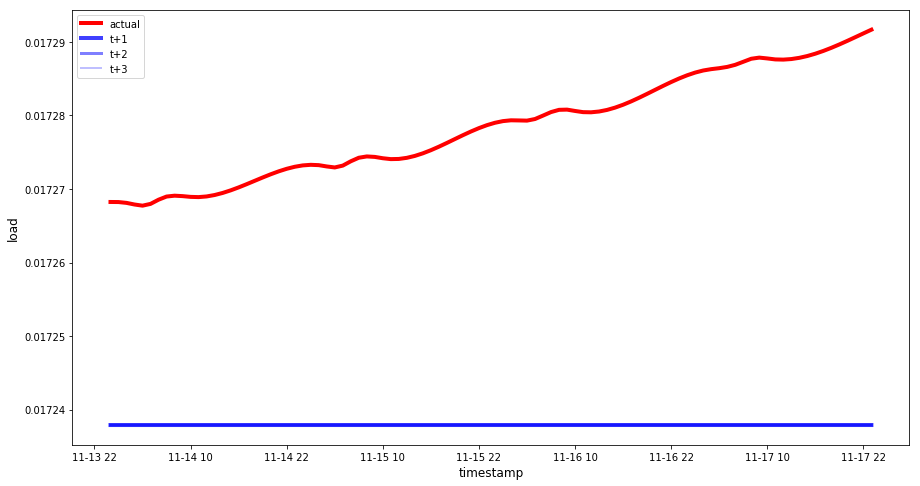

In [177]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [178]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [179]:
new_df = pd.DataFrame()

In [184]:
columns = Paras[var_name]

In [185]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [186]:
new_df = new_df.dropna( how = 'any')

In [187]:
new_df

,e
Epoch_Time_of_Clock,
2017-11-21 00:00:00,0.01731012380000000045
2017-11-21 01:00:00,0.01731043319999999927
2017-11-21 02:00:00,0.01731079439999999928
2017-11-21 03:00:00,0.01731121350000000211
2017-11-21 04:00:00,0.01731169379999999980
2017-11-21 05:00:00,0.01731216650000000010
2017-11-21 06:00:00,0.01731249659999999774
2017-11-21 07:00:00,0.01731267419999999932
2017-11-21 08:00:00,0.01731281620000000090


In [188]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [189]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [190]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [191]:
new_df.index= date

In [192]:
new_df.columns

Index(['e'], dtype='object')

In [193]:
print(new_df)
print(new_df.columns)

                                         e
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 0.01731012380000000045
2017-11-22 01:00:00 0.01731043319999999927
2017-11-22 02:00:00 0.01731079439999999928
2017-11-22 03:00:00 0.01731121350000000211
2017-11-22 04:00:00 0.01731169379999999980
2017-11-22 05:00:00 0.01731216650000000010
2017-11-22 06:00:00 0.01731249659999999774
2017-11-22 07:00:00 0.01731267419999999932
2017-11-22 08:00:00 0.01731281620000000090
2017-11-22 09:00:00 0.01731299979999999933
2017-11-22 10:00:00 0.01731325460000000122
2017-11-22 11:00:00 0.01731356170000000055
2017-11-22 12:00:00 0.01731385669999999793
2017-11-22 13:00:00 0.01731410870000000060
2017-11-22 14:00:00 0.01731432249999999978
2017-11-22 15:00:00 0.01731450450000000113
2017-11-22 16:00:00 0.01731466109999999989
2017-11-22 17:00:00 0.01731479850000000251
2017-11-22 18:00:00 0.01731492320000000210
2017-11-22 19:00:00 0.01731504139999999817
2017-11-22 20:00:00 0.01731515949999999984
2017-11-22 

In [194]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['Crs', 'e', 'Cus', 'OMEGA', 'i0', 'omega', 'I_dot']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['Crs', 'e', 'Cus', 'OMEGA', 'i0', 'omega', 'I_dot'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

KeyError: "['Crs' 'Cus' 'OMEGA' 'i0' 'omega' 'I_dot'] not in index"

In [195]:
print(new_new_df)
print(inputs['X'])

NameError: name 'new_new_df' is not defined

In [196]:
predictions = model.predict(inputs['X'])

NameError: name 'inputs' is not defined

In [197]:
predictions

array([[13.435229, 13.435229, 13.435229, ..., 13.435229, 13.435229,
        13.435229],
       [13.435176, 13.435176, 13.435176, ..., 13.435176, 13.435176,
        13.435176],
       [13.435123, 13.435123, 13.435123, ..., 13.435123, 13.435123,
        13.435123],
       ...,
       [13.435808, 13.435808, 13.435808, ..., 13.435808, 13.435808,
        13.435808],
       [13.435786, 13.435786, 13.435786, ..., 13.435786, 13.435786,
        13.435786],
       [13.435759, 13.435759, 13.435759, ..., 13.435759, 13.435759,
        13.435759]], dtype=float32)

In [198]:
print(predictions.shape)


(96, 24)


In [199]:
results = predictions[-1, :]

In [200]:
results

array([13.435759, 13.435759, 13.435759, 13.435759, 13.435759, 13.435759,
       13.435759, 13.435759, 13.435759, 13.435759, 13.435759, 13.435759,
       13.435759, 13.435759, 13.435759, 13.435759, 13.435759, 13.435759,
       13.435759, 13.435759, 13.435759, 13.435759, 13.435759, 13.435759],
      dtype=float32)

In [201]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,e
0,13.43575859069824218750
1,13.43575859069824218750
2,13.43575859069824218750
3,13.43575859069824218750
4,13.43575859069824218750
5,13.43575859069824218750
6,13.43575859069824218750
7,13.43575859069824218750
8,13.43575859069824218750
9,13.43575859069824218750


In [202]:
res_df.index = date
res_df

,e
Epoch_Time_of_Clock,
2017-11-22 00:00:00,13.43575859069824218750
2017-11-22 01:00:00,13.43575859069824218750
2017-11-22 02:00:00,13.43575859069824218750
2017-11-22 03:00:00,13.43575859069824218750
2017-11-22 04:00:00,13.43575859069824218750
2017-11-22 05:00:00,13.43575859069824218750
2017-11-22 06:00:00,13.43575859069824218750
2017-11-22 07:00:00,13.43575859069824218750
2017-11-22 08:00:00,13.43575859069824218750


In [203]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [204]:
# final generated ouput
res_df['actual'] = Actual
res_df

,e,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,0.01723790541291236877,0.01731575800000000054
2017-11-22 01:00:00,0.01723790541291236877,0.01731597090000000158
2017-11-22 02:00:00,0.01723790541291236877,0.01731622179999999997
2017-11-22 03:00:00,0.01723790541291236877,0.01731651700000000002
2017-11-22 04:00:00,0.01723790541291236877,0.01731686259999999991
2017-11-22 05:00:00,0.01723790541291236877,0.01731725809999999990
2017-11-22 06:00:00,0.01723790541291236877,0.01731769370000000099
2017-11-22 07:00:00,0.01723790541291236877,0.01731809150000000047
2017-11-22 08:00:00,0.01723790541291236877,0.01731831359999999945


In [205]:
res_df.to_csv('SA2e.csv')